In [1]:
import pathlib
import os
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

from sklearn.metrics import classification_report

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
df_pca_train = pd.read_csv("../pca_reducted_kvasir_seg/train_pca_kvasir.csv", index_col=0)
df_pca_train

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
cju43jcqim2cp08172dvjvyui,-2829.419859,-4360.309411,-575.059686,1007.094318,4562.158640,-883.438753,-69.868939,1725.233639,-1711.060824,-999.529970,...,-44.676451,114.288722,20.866908,-37.097454,-209.677129,-35.224785,-16.851047,114.504894,72.554146,-41.800830
cju88oh0po9gq0801nge4tgr1,-516.297794,-5386.019764,-1471.249504,2471.775313,-828.526101,2759.242421,256.652930,47.824027,-497.403221,1113.931868,...,4.853969,-16.652698,53.269610,-83.803114,-34.860047,-143.235185,-70.299848,16.283228,90.708129,-1.834795
cju45rj7ln8980850a7821fov,-2989.770061,-2558.644601,-2974.837212,-3068.348387,-3022.624719,-1574.522367,-1070.869399,-45.941306,-100.983416,905.280411,...,-34.311425,94.718882,-20.698240,-203.332440,-53.857884,7.651053,-120.300438,18.094047,84.607145,-263.666354
cju5hwonqedw10801vsd3w6kk,1539.473072,1843.359953,-1086.343915,3024.463496,-2475.832786,1763.051573,-385.294952,-498.515954,-136.304413,2003.789081,...,-17.013456,-192.648105,3.499378,126.607786,-12.634792,-80.285525,-100.132258,-56.747742,54.610658,111.832531
cju8dm2cau2km0818jsv9eeq2,986.914127,-4013.177708,-5294.217474,-1189.628866,1745.764914,2770.921274,-4236.044639,-284.615932,-3233.357083,1928.534849,...,-0.058568,-42.012987,-41.720214,57.370761,-51.408808,17.326587,41.413629,-48.637554,105.648122,16.147830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cju5v8pgplg6k0755rvi2t63h,-336.593048,6217.733553,5752.746816,-749.010361,2215.462002,335.772625,-1283.862929,-1873.475729,966.929337,1184.897512,...,3.689052,289.687525,-35.172332,118.614881,-162.672673,-119.394928,131.552617,-15.317916,-185.079505,-69.209368
cju2htabevq9108015qjei0x7,-5957.484171,-2257.143676,1168.685153,1520.690698,-2616.558776,-4513.929859,1895.456089,-1684.475886,-2405.612723,-1659.792496,...,43.580586,-172.380468,-27.530237,26.518656,20.600893,-114.718442,-20.069842,-100.430861,158.355433,-2.692102
cju5vbo6jldrt0871jf6f1700,-7042.096402,-2534.083826,1257.557689,-6674.670390,-1375.725261,4696.164410,-1451.657865,4032.451929,-73.317809,-1628.076774,...,75.027284,6.894385,7.000588,-151.521375,-59.280503,-129.239142,-200.741809,-51.916895,-110.983819,33.256159
cju414lf2l1lt0801rl3hjllj,3033.751099,5149.715549,-132.858255,-2866.178580,-2935.555271,-571.261223,1882.331310,535.736781,6.803848,784.868660,...,108.845388,154.005633,11.161193,36.286864,-122.886505,-4.421915,94.475729,39.829909,-79.266912,-47.005902


In [4]:
df_pca_test = pd.read_csv("../pca_reducted_kvasir_seg/test_pca_kvasir.csv", index_col=0)
df_pca_test

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
cju7ejm2l2ncl0801wq6y84nw,-3247.901488,-2592.028653,-3601.535889,-3286.960363,126.876492,-1184.741814,-125.394669,853.158284,68.141525,1434.811269,...,17.880308,-14.744217,-5.666535,-36.192289,56.992746,-42.751756,-13.593211,-39.855969,93.853048,-135.654097
cju87xn2snfmv0987sc3d9xnq,-3236.812333,6785.064213,-4037.894249,-1117.141357,-4072.582740,1905.797675,-662.744132,5311.157740,-2927.568563,1923.996461,...,-100.664348,-89.445430,-37.976767,9.643125,-48.799404,34.001873,-115.338072,51.192977,-162.180478,37.480926
cju85rkbnlo1c08503uxcpax1,-678.405249,-4614.874903,-3238.382072,-1482.517852,2003.784046,3762.199413,-1062.834462,-205.499350,45.110220,-140.490884,...,100.164697,-17.001187,-23.912073,-53.638350,-2.047129,-55.388221,-60.287693,-64.868606,35.952600,54.171303
cju84kplnl1y30755ropua1b0,3014.818076,4422.615417,-872.872541,2983.651159,-1798.877180,-1853.045905,-1981.500437,1277.124059,2622.820540,-1973.526671,...,-45.367175,5.478910,79.876102,-28.264808,-20.716685,109.876319,-75.723812,8.274081,58.614832,-79.026188
cju5uhrdwkmsu0817ervv91l8,-5096.548194,-2221.115728,-2332.650132,-4433.462513,2110.834537,-2421.571457,5128.982301,-1185.729704,-1553.497705,1731.164092,...,-76.663647,8.764742,163.155890,18.949317,-43.121119,-98.471144,-5.776646,4.770989,-89.648310,86.410256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cju5enq1tcn1i0755hnkon787,-365.370681,-1284.167975,-2620.629242,3211.540483,4528.056239,112.083685,1951.424697,1449.988889,281.751985,1441.050191,...,-1.769907,-19.567602,-33.388691,68.505512,-7.129114,13.768779,40.527206,38.945671,-20.534976,23.893247
cju5fs6j6d8350801vglraq4u,207.627862,-961.793013,-4227.604562,1349.979667,1834.763674,2329.799920,-827.970417,1677.332458,896.130151,2010.741031,...,-41.706276,-161.904810,1.850170,7.331059,-72.846011,-78.150291,20.064504,-45.318911,-58.376231,19.481426
cju5bf6hxa6m50817rbwettgu,-2524.079319,-1376.768151,-1785.777901,564.444513,3577.435605,1876.974705,-3088.712428,-1631.510404,-2912.904903,1711.603211,...,23.485479,-18.579849,-38.328696,-127.929817,-30.321774,-12.445311,5.539556,-14.064536,-3.147601,12.213137
cju5vcmrqla7i0817x4sp4pqw,-579.226266,1489.744597,510.065782,539.031786,-3757.489594,-4539.790060,3301.900782,2111.154085,3028.076067,-124.431252,...,-65.920193,47.494469,-48.798831,-24.219051,60.389309,120.651327,-110.973316,28.520442,-41.622786,25.881936


In [5]:
# load the images and masks
dir_images_train = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/train/images')
dir_masks_train = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/train/masks')
dir_images_test = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/test/images')
dir_masks_test = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/test/masks')

In [6]:
train_ids = [f.stem for f in dir_images_train.glob("*.jpg")]
test_ids = [f.stem for f in dir_images_test.glob("*.jpg")]

In [7]:
train_ids = train_ids[:8]

In [8]:
len(train_ids), len(test_ids)

(8, 182)

In [9]:
class KvasirSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, pca_data, ids, transform=None):
        """
        Args:
            image_dir (pathlib.Path): Directory with all the images.
            mask_dir (pathlib.Path): Directory with all the masks.
            pca_data (pd.DataFrame): DataFrame containing PCA features.
            ids (list): List of image/mask IDs (without extensions).
            transform (callable, optional): Optional additional transform to be applied on an image/mask.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.pca_data = pca_data
        self.ids = ids
        self.transform = transform
        self.to_tensor = ToTensor()  # Define ToTensor transformation

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        name = self.ids[idx]
        # Load image and mask
        image = np.array(Image.open(self.image_dir / f"{name}.jpg").convert("RGB"))
        #image = np.array(image)#.transpose(1, 2, 0) # transform from CHW to HWC
        mask = np.array(Image.open(self.mask_dir / f"{name}.jpg").convert("L")) / 255
        #mask = np.array(mask)

        # Apply ToTensor transformation
        #image = self.to_tensor(image)
        #mask = self.to_tensor(mask)

        # Load PCA features
        image_pca = self.pca_data.loc[name].values.astype(np.float32)

        ## Apply additional transformations if provided
        #if self.transform:
        #    image = self.transform(image)
        #    mask = self.transform(mask)

        return image, mask, torch.tensor(image_pca)


In [10]:
# Create datasets with transformations
dataset_train = KvasirSegDataset(dir_images_train, dir_masks_train, df_pca_train, train_ids)
dataset_test = KvasirSegDataset(dir_images_test, dir_masks_test, df_pca_test, test_ids)

# Create dataloaders
train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=8, shuffle=False, num_workers=4)

In [11]:
torch.nn.LeakyReLU

torch.nn.modules.activation.LeakyReLU

In [12]:
# create a custom neural network model that takes the pca values as input and outputs two cordinates for one point that will be used as a prompt for the sam2 model
# use 3 layers with 100 neurons each and a tanh activation function, the output must be between 0 and 1

class CustomModel(torch.nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.fc1 = torch.nn.Linear(512, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 2)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        # multiply by 128 and convert to int
        x = (x * 128) - 1
        return x
    
model = CustomModel()
model.to(device)

CustomModel(
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [13]:
def register_hooks(module):
    def hook(module, grad_input, grad_output):
        print(f"{module}:")
        print(f"Grad Input: {[g.mean().item() if g is not None else None for g in grad_input]}")
        print(f"Grad Output: {[g.mean().item() if g is not None else None for g in grad_output]}")

    module.register_backward_hook(hook)

# Apply hooks to all layers
for name, module in model.named_modules():
    if isinstance(module, (torch.nn.Linear, torch.nn.Conv2d, torch.nn.ReLU)):  # Add more layer types as needed
        register_hooks(module)

In [14]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Layer {name} - Initial Weights Mean: {param.data.mean().item()}, Std: {param.data.std().item()}")

Layer fc1.weight - Initial Weights Mean: -6.017797568347305e-05, Std: 0.025509098544716835
Layer fc1.bias - Initial Weights Mean: -0.0010168992448598146, Std: 0.025883173570036888
Layer fc2.weight - Initial Weights Mean: 0.00022365551558323205, Std: 0.035984307527542114
Layer fc2.bias - Initial Weights Mean: 0.0021666926331818104, Std: 0.036397535353899
Layer fc3.weight - Initial Weights Mean: 0.0030856160447001457, Std: 0.05340966209769249
Layer fc3.bias - Initial Weights Mean: -0.018975432962179184, Std: 0.030715053901076317


In [15]:
# print weights tensors
print(model.fc1.weight)
print(model.fc2.weight)
print(model.fc3.weight)

Parameter containing:
tensor([[-0.0295,  0.0113,  0.0371,  ..., -0.0312,  0.0068, -0.0100],
        [-0.0361, -0.0433, -0.0225,  ...,  0.0241,  0.0051, -0.0423],
        [-0.0116, -0.0077, -0.0332,  ..., -0.0361, -0.0321, -0.0311],
        ...,
        [-0.0369,  0.0387, -0.0390,  ..., -0.0052,  0.0127,  0.0270],
        [ 0.0304,  0.0167, -0.0081,  ...,  0.0159,  0.0076, -0.0316],
        [-0.0252,  0.0309,  0.0294,  ...,  0.0201,  0.0283, -0.0358]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0024,  0.0085,  0.0449,  ...,  0.0016, -0.0004,  0.0342],
        [ 0.0248, -0.0045,  0.0415,  ..., -0.0499,  0.0273,  0.0063],
        [-0.0040, -0.0564,  0.0037,  ..., -0.0026,  0.0607,  0.0137],
        ...,
        [-0.0125, -0.0546,  0.0172,  ...,  0.0047,  0.0298,  0.0277],
        [-0.0386, -0.0401,  0.0185,  ..., -0.0285, -0.0476,  0.0088],
        [ 0.0061,  0.0160, -0.0553,  ..., -0.0150, -0.0243, -0.0359]],
       device='cuda:0', requires_grad=True)


In [16]:
# test model with a random input
x = torch.randn(512).to(device)
y = model(x)
print(y)

tensor([66.7978, 57.5289], device='cuda:0', grad_fn=<SubBackward0>)


/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [17]:
# test model with the first image pca values from the train dataset
for i, (image, mask, image_pca) in enumerate(train_loader):
    image_pca = image_pca.to(device)
    y = model(image_pca)
    print(y.int())
    break

tensor([[58, 49],
        [60, 46],
        [63, 62],
        [68, 52],
        [64, 68],
        [54, 60],
        [61, 59],
        [70, 83]], device='cuda:0', dtype=torch.int32)


In [18]:
image[0].shape

torch.Size([128, 128, 3])

In [19]:
mask[0].shape

torch.Size([128, 128])

In [20]:
mask[0].max(), mask[0].min()

(tensor(1., dtype=torch.float64), tensor(0., dtype=torch.float64))

In [21]:
# build the sam2 model
sam2_checkpoint = "../../sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

In [22]:
# test the sam2 model with the first image from the train dataset
for i, (images, target_masks, images_pca) in enumerate(train_loader):
    target_masks = target_masks
    images_pca = images_pca.to(device)
    y = model(images_pca).int()
    #print(y)
    prompt_labels = torch.ones((y.shape[0], 1))
    #print(prompt_labels)
    #print(np.array(images).shape)
    images_list = [ np.array(image) for image in images ]
    coords_list = [ [y[i].tolist(), [128,128], [128,0], [0,128], [0,0]] for i in range(y.shape[0]) ]
    labels_list = [ prompt_labels[i].tolist() + [0.]*4 for i in range(prompt_labels.shape[0]) ]

    predictor.set_image_batch(images_list)
    #print(y.unsqueeze(0))
    #print(prompt_labels[i])
    masks, _, _ = predictor.predict_batch(point_coords_batch=coords_list, point_labels_batch=labels_list, multimask_output=False)
    break

In [23]:
masks = np.array(masks)
masks.shape

(8, 1, 128, 128)

In [24]:
masks[0].shape

(1, 128, 128)

In [25]:
masks[0].max(), masks[0].min()

(1.0, 0.0)

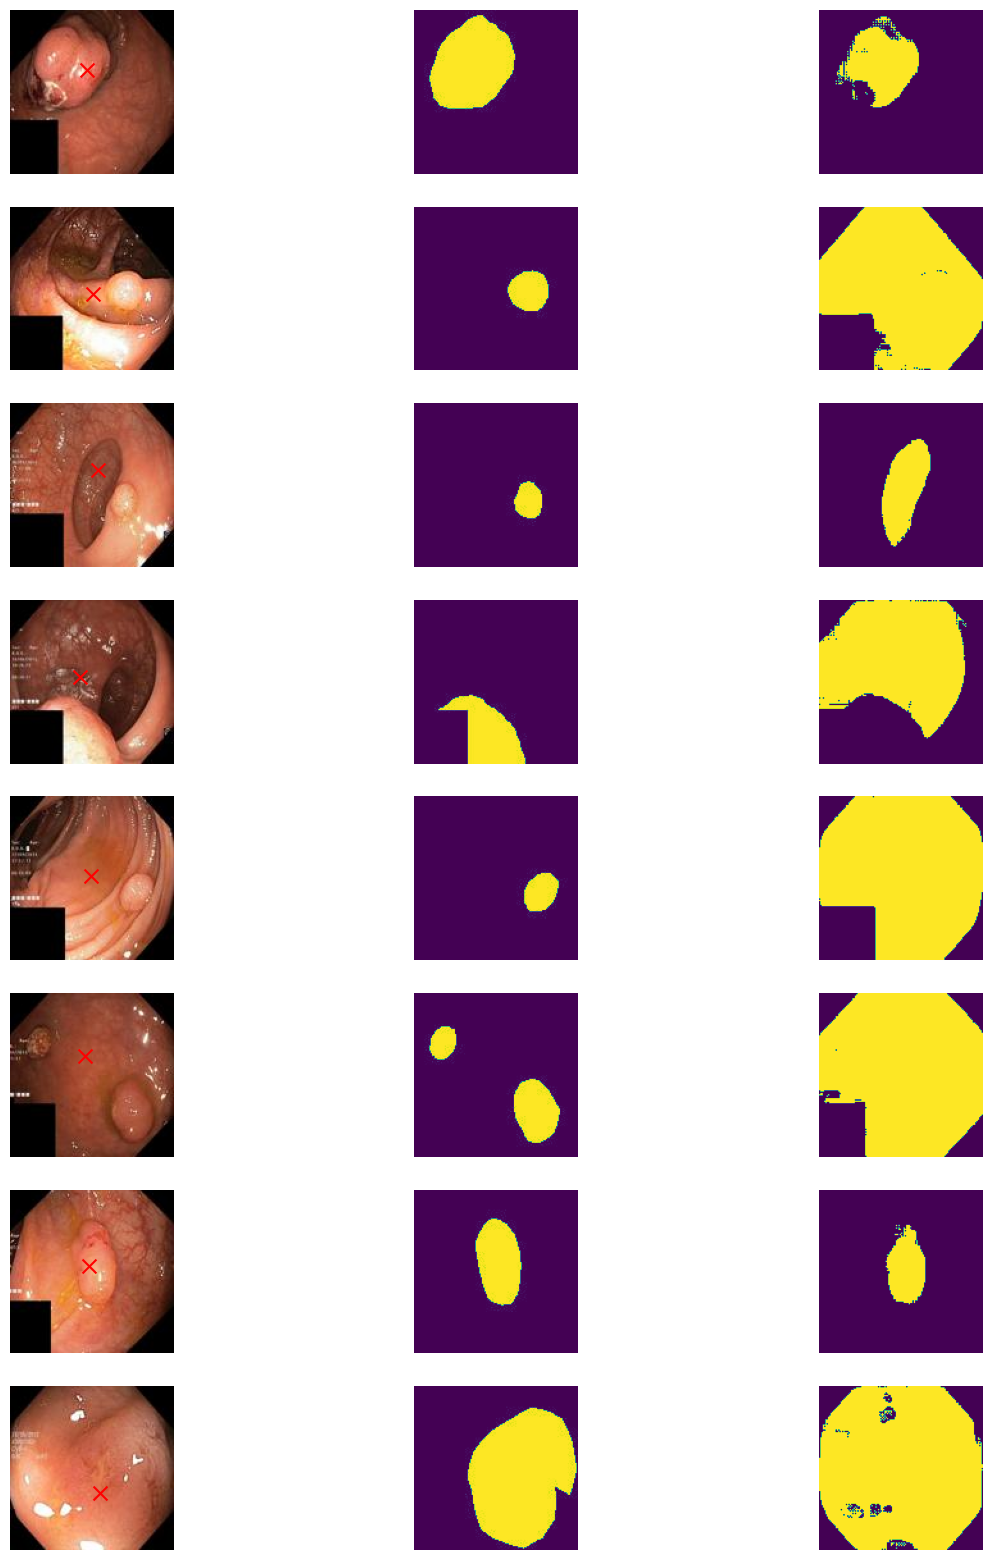

In [26]:
# visualize original images, prompt points, target masks and predicted masks
plt.figure(figsize=(20, 20))
for i in range(8):
    plt.subplot(8, 4, 4 * i + 1)
    plt.imshow(images[i])
    plt.scatter(y[i][0].cpu(), y[i][1].cpu(), c="r", s=100, marker="x")
    plt.axis("off")
    plt.subplot(8, 4, 4 * i + 2)
    plt.imshow(target_masks[i])
    plt.axis("off")
    plt.subplot(8, 4, 4 * i + 3)
    plt.imshow(masks[i].transpose(1, 2, 0))
    plt.axis("off")
plt.show()

In [27]:
from IPython.display import clear_output, display

In [ ]:
# Training custom model with REINFORCE

# Hyperparameters
input_dim = 10
output_dim = 2  # 2D points
num_points = 5
num_epochs = 2
batch_size = 8
learning_rate = 1000.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()

# Training Loop
for epoch in range(num_epochs):
    for i, (images, target_masks, images_pca) in enumerate(train_loader):
        target_masks = np.array(target_masks)
        images_pca = images_pca.to(device)
        images_pca.requires_grad_(True)
        points = model(images_pca)

        prompt_labels = torch.ones((y.shape[0], 1))
        images_list = [ np.array(image) for image in images ]
        coords_list = [ [y[i].int().tolist(), [128,128], [128,0], [0,128], [0,0]] for i in range(y.shape[0]) ]
        labels_list = [ prompt_labels[i].tolist() + [0.]*4 for i in range(prompt_labels.shape[0]) ]

        predictor.set_image_batch(images_list)
        masks, _, _ = predictor.predict_batch(point_coords_batch=coords_list, point_labels_batch=labels_list, multimask_output=False)
        masks = np.array(masks).squeeze(1)

        # 1. Compute rewards (Intersection over Union)
        rewards = torch.zeros(batch_size).to(device)
        for j in range(batch_size):
            intersection = (masks[j] * target_masks[j]).sum()
            union = (masks[j] + target_masks[j]).sum()
            iou = intersection / union
            rewards[j] = (1 + iou) * 10
        # Normalize rewards (optional but improves stability)
        #rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        #rewards = rewards.detach()

        # 2. REINFORCE: Compute log probabilities of the points (policy log-probabilities)
        # Assume Gaussian sampling with mean = generated points
        distribution = torch.distributions.Normal(points.unsqueeze(0), torch.tensor(0.1).to(device))
        # create a 128x128 grid of points using the distribution, then calculate ioU with the target mask
        grid = torch.stack(torch.meshgrid(torch.arange(0, 128), torch.arange(0, 128)), dim=-1).to(device)
        
        sampled_points = distribution.rsample()
        log_probs = distribution.log_prob(sampled_points).mean(dim=(0,2))
        print("LOG PROBS ", log_probs)

        # 3. REINFORCE: Scale log_probs by rewards
        print("Rewards: ", rewards)
        loss = -torch.mean(rewards * log_probs) * 10000 # Negative reward for gradient ascent
        print(f"Rewards Mean: {rewards.mean().item()}, Std: {rewards.std().item()}")
        print(f"Log Probs Mean: {log_probs.mean().item()}, Std: {log_probs.std().item()}")
    
        # 4. Backpropagate and update weights
        for name, param in model.named_parameters():
            if param.requires_grad:
                if param.grad is not None:
                    print(f"Before Backprop - {name}: {param.grad}")
                else:
                    print(f"Before Backprop - {name}: No gradient")
        print(f"Loss grad_fn: {loss.grad_fn}")
        optimizer.zero_grad()
        loss.backward()
        for name, param in model.named_parameters():
            if param.requires_grad:
                if param.grad is not None:
                    print(f"After Backprop - {name}: {param.grad}")
                else:
                    print(f"After Backprop - {name}: No gradient")
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"Layer {name} - Grad Mean: {param.grad.mean().item()}, Std: {param.grad.std().item()}, Min: {param.grad.min().item()}, Max: {param.grad.max().item()}")
        optimizer.step()
        # plot prompt points, target masks and predicted masks
        ## Update visualization
        #clear_output(wait=True)  # Clear previous plots
        #fig, ax = plt.subplots(2, 8, figsize=(20, 10))  # Create subplots for 8 batches
        #for b in range(min(batch_size, 8)):
        #    ax[0, b].imshow(target_masks[b], cmap="gray")
        #    ax[0, b].set_title("Target Mask + Prompt")
        #    ax[0, b].scatter(coords_list[b][0][0], coords_list[b][0][1], c="r", s=100, marker="x")
        #    ax[0, b].axis("off")
        #    ax[1, b].imshow(masks[b], cmap="gray")
        #    ax[1, b].set_title("Predicted Mask")
        #    ax[1, b].axis("off")
        #display(fig)  # Display the updated plot
        #plt.close(fig)  # Close the figure to prevent redundant plots

    # Logging
    print(f"Epoch {epoch}, Batch {i+1} of {len(train_loader)}: Loss = {loss.item()}, Mean Reward = {rewards.mean().item()}")
#plt.ioff()
#plt.show()

Rewards requires_grad: False
Log Probs requires_grad: True
LOG PROBS  tensor([ 0.8122,  1.1895,  0.3197,  0.4215,  1.2777,  1.3253, -0.3446,  0.8343],
       device='cuda:0', grad_fn=<MeanBackward1>)
Rewards:  tensor([14.3846, 10.4462, 10.0030, 11.1625, 10.0057, 10.2393, 13.2828, 10.4576],
       device='cuda:0')
Rewards Mean: 11.247699737548828, Std: 1.6632510423660278
Log Probs Mean: 0.7294507026672363, Std: 0.5733875632286072
Before Backprop - fc1.weight: No gradient
Before Backprop - fc1.bias: No gradient
Before Backprop - fc2.weight: No gradient
Before Backprop - fc2.bias: No gradient
Before Backprop - fc3.weight: No gradient
Before Backprop - fc3.bias: No gradient
Loss grad_fn: <MulBackward0 object at 0x7d0e8e31c3a0>
Linear(in_features=128, out_features=2, bias=True):
Grad Input: [0.0, 0.0, 0.0]
Grad Output: [0.0]
Linear(in_features=256, out_features=128, bias=True):
Grad Input: [0.0, 0.0, 0.0]
Grad Output: [0.0]
Linear(in_features=512, out_features=256, bias=True):
Grad Input: [

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Rewards requires_grad: False
Log Probs requires_grad: True
LOG PROBS  tensor([0.2851, 1.0386, 1.2761, 1.3583, 1.3339, 1.0095, 0.3796, 1.1606],
       device='cuda:0', grad_fn=<MeanBackward1>)
Rewards:  tensor([14.3846, 10.4573, 10.0030, 10.0073, 11.1641, 10.0054, 13.2828, 12.1846],
       device='cuda:0')
Rewards Mean: 11.436140060424805, Std: 1.6834708452224731
Log Probs Mean: 0.9802024364471436, Std: 0.4202447533607483
Before Backprop - fc1.weight: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
Before Backprop - fc1.bias: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.

In [29]:
# augment the number of points to 10